In [1]:
import h5py
import numpy as np
import datetime
import matplotlib.pyplot as plt
from pyproj import Proj, Transformer
from scipy.spatial.kdtree import KDTree
from netCDF4 import Dataset
import warnings
warnings.filterwarnings("ignore")

/var/folders/_1/fh2vf5m57871c546k_sf7xr80000gn/T/ipykernel_21600/2149894352.py:6: DeprecationWarning: Please use `KDTree` from the `scipy.spatial` namespace, the `scipy.spatial.kdtree` namespace is deprecated.
  from scipy.spatial.kdtree import KDTree


### load BGEP buoy data and visualize

In [2]:
filepath = '/Users/carmennab/Dropbox/met_office/BGEP/uls18a_dailyn.mat' # there are three buoys, i'm just using one here

with h5py.File(filepath, 'r') as f:
    all_drafts = f['IDS'][1,:] # load sea ice draft
    std = f['IDS'][2,:] # load standard deviation
    drafts = all_drafts[std<=2] # we normally filter out values with an STD > 2m
    
# create dates list
days = np.arange(0,len(drafts)) # file contains daily averages, so one number per day
dates = [datetime.date(2018,9,25)+datetime.timedelta(days=np.int(days)) for days in days] # buoy A starts on 25/09/2018

([<matplotlib.axis.XTick at 0x7fdf2af7ea90>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

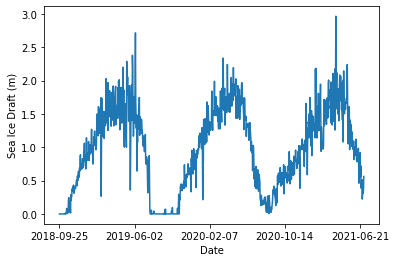

In [3]:
# quick plot to check data loaded correctly (as michel always says: visualise, visualise, visualise)
plt.plot(dates,drafts)
plt.ylabel('Sea Ice Draft (m)')
plt.xlabel('Date')
x_labels = dates[::250] # label every 250th date
plt.xticks(x_labels)

### find nearest EASE grid cell for buoy coords

In [4]:
def lonlat_to_xy(coords_1, coords_2, hemisphere, inverse=False):

    """Converts between longitude/latitude and EASE xy coordinates.
 
    Args:
        lon (float): WGS84 longitude
        lat (float): WGS84 latitude
        hemisphere (string): 'n' or 's'
        inverse (bool): if true, converts xy to lon/lat
 
    Returns:
        tuple: pair of xy or lon/lat values
    """

    EASE_Proj = {'n': 'EPSG:3408',
                 's': 'EPGS:3409'}
    
    WGS_Proj = 'EPSG:4326'
    
    for coords in [coords_1, coords_2]: assert isinstance(coords,(np.ndarray,list))

    if inverse == False: # lonlat to xy
        
        lon, lat = coords_1, coords_2
        
        transformer = Transformer.from_crs(WGS_Proj, EASE_Proj[hemisphere])
        
        x, y = transformer.transform(lat, lon)
        
        return (x, y)

    else: # xy to lonlat
        
        x, y = coords_1, coords_2
        
        transformer = Transformer.from_crs(EASE_Proj[hemisphere], WGS_Proj)
        
        lat, lon = transformer.transform(x, y)
        
        return (lon, lat)

In [5]:
# the buoys stay stationary at a fixed coordinate:
buoy_lat = 75.00079
buoy_lon = -149.599659

# convert lon,lat into x,y:
buoy_x,buoy_y = lonlat_to_xy(np.array(buoy_lon),
                       np.array(buoy_lat),
                       hemisphere='n')

In [6]:
# load ease lons,lats:
ease_lats = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/data/SMLG_sden_EASE.nc')['Latitude'])
ease_lons = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/data/SMLG_sden_EASE.nc')['Longitude'])

# convert into x,y:
ease_x, ease_y = lonlat_to_xy(ease_lons,ease_lats,hemisphere='n')

# get index of EASE grid cell closest to buoy:
tree = KDTree(list(zip(ease_x.ravel(),ease_y.ravel())))

ease_inds = {}

dist, ind = tree.query([buoy_x,buoy_y])

ind2d = np.unravel_index(ind, (360,360))

print(ind2d)

(237, 146)


In [7]:
# find SM-LG snow depth and density on example day to check everything worked:
# (my SM-LG files run from 01/01/2010 - 31/12/2020 so just selecting from 25/9/2018 onwards)
sden = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/data/SMLG_sden_EASE.nc')['Snow Density'])[3189:] 
snod = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/data/SMLG_snod_EASE.nc')['Snow Depth'])[3189:]

sden_buoy_a = sden[100][ind2d] 
snod_buoy_a = snod[100][ind2d] 

print('snow density on day 0:',sden_buoy_a)
print('snow depth on day 0:',snod_buoy_a)

snow density on day 0: 191.9009839875209
snow depth on day 0: 0.05281627657442456


### turn sea ice draft into freeboard

rearranging Eq. 2 from Kern et al. 2015 (doi.org/10.5194/tc-9-37-2015):

# $f_b = \frac{D(\rho_w-\rho_i)-Z_s\rho_s}{\rho_i}$

assuming ice freeboard = radar freeboard

In [8]:
# create array of snow depth and density
days = np.arange(0,len(sden))

sdens_buoy_a = [sden[day][ind2d] for day in days]
snods_buoy_a = [snod[day][ind2d] for day in days]

In [9]:
# calculate freeboard for each day:

def draft_to_freeboard(day):
    
    D = drafts[day]
    rho_w = 1030
    rho_i = 900
    Zs = snods_buoy_a[day]
    rho_s = sdens_buoy_a[day]

    fb = ((D*(rho_w-rho_i))-(Zs*rho_s)) / rho_i
    
    return(fb)

freeboards = [draft_to_freeboard(day) for day in days]

Text(0, 0.5, 'Freeboard (m)')

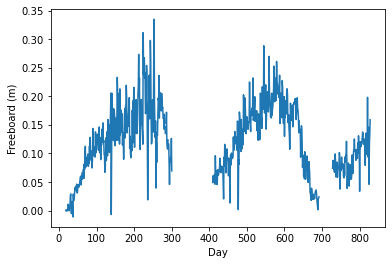

In [10]:
plt.plot(days,freeboards)
plt.xlabel('Day')
plt.ylabel('Freeboard (m)')

In [11]:
### some nans above because I'm missing some of the SM-LG data, but you get the idea